In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
df = pd.read_excel("kaggle_plus_worldbank_joined_uncleaned_v4.xlsx")

In [13]:
df['Year'] = pd.to_datetime(df['Year'], format='%m-%d-%y').dt.year

df.head(5)

,Year,Entity,Renewables (% electricity),Renewable energy consumption (% of total final energy consumption),Renewable electricity output (% of total electricity output),Energy use (kg of oil equivalent per capita),GDP (current US$),"Energy imports, net (% of energy use)",Investment in renewable energy (USD),Total Population,Population Ages 65 and Above (% of total),Population Ages 15-64 (% of total),Population Ages 0-14 (% of total),Rural population (% of population),Access to electricity (% of population),"Industry (including construction), Value Added (% of GDP)"
0,1990,Albania,86.36364,25.5,86.407767,813.255696,2.028554e+09,7.965058,0,3286542,5.737989,61.698500,32.563510,63.572,100.0,17.373841
1,1991,Albania,92.14660,33.0,92.142483,572.781844,1.099559e+09,-2.783624,0,3266790,5.872114,61.735863,32.392023,63.300,100.0,17.373841
2,1992,Albania,95.00000,46.8,95.050088,418.286630,6.521750e+08,-3.376251,0,3247039,6.024280,61.744436,32.231284,62.751,100.0,17.373841
3,1993,Albania,93.76771,51.1,93.907623,412.378880,1.185315e+09,-0.097756,0,3227287,6.194681,61.733603,32.071716,62.201,100.0,17.373841
4,1994,Albania,95.68528,51.4,95.686374,441.249295,1.880951e+09,9.330732,0,3207536,6.381682,61.713644,31.904675,61.646,100.0,17.373841


In [14]:
##generating a list of unique countries
unique_countries = df['Entity'].unique()

In [15]:
# Define features for PCA
features = ['Renewables (% electricity)', 'Renewable energy consumption (% of total final energy consumption)',
           'Renewable electricity output (% of total electricity output)', 'Energy use (kg of oil equivalent per capita)',
           'Energy imports, net (% of energy use)']

In [16]:
#Assigning countries to continents for easier identification later on.  
##The middle east is not a continent but it has a cluster of countries with a unique energy profile.  
def assign_continent(country):
    continent_dict = {
        'Asia': [
            # East Asia
            'China', 'Japan', 'South Korea', 'North Korea', 'Mongolia', 'Taiwan', 
            # Southeast Asia
            'Indonesia', 'Thailand', 'Malaysia', 'Vietnam', 'Philippines', 'Singapore', 
            'Myanmar', 'Cambodia', 'Laos', 'Brunei', 'Timor-Leste',
            # South Asia
            'India', 'Pakistan', 'Bangladesh', 'Sri Lanka', 'Nepal', 'Bhutan', 'Maldives',
            # Central Asia
            'Kazakhstan', 'Uzbekistan', 'Kyrgyzstan', 'Tajikistan', 'Turkmenistan'
        ],
        
        'Middle East': [
            'Saudi Arabia', 'Iran', 'Iraq', 'Turkey', 'Syria', 'Yemen', 'United Arab Emirates',
            'Israel', 'Lebanon', 'Jordan', 'Oman', 'Kuwait', 'Qatar', 'Bahrain', 'Palestine',
            'Armenia', 'Azerbaijan', 'Georgia'
        ],
        
        'Europe': [
            # Western Europe
            'Germany', 'United Kingdom', 'France', 'Italy', 'Spain', 'Portugal', 
            'Netherlands', 'Belgium', 'Austria', 'Switzerland', 'Luxembourg', 'Monaco',
            # Northern Europe
            'Sweden', 'Norway', 'Denmark', 'Finland', 'Iceland', 'Ireland',
            'Estonia', 'Latvia', 'Lithuania',
            # Eastern Europe
            'Poland', 'Romania', 'Czech Republic', 'Hungary', 'Slovakia', 'Belarus', 
            'Ukraine', 'Russia', 'Moldova',
            # Southern Europe
            'Greece', 'Bulgaria', 'Croatia', 'Slovenia', 'Bosnia and Herzegovina', 
            'Serbia', 'Albania', 'North Macedonia', 'Montenegro', 'Malta', 'Cyprus',
            'Vatican City', 'San Marino', 'Andorra', 'Liechtenstein'
        ],
        
        'North America': [
            # Northern America
            'United States', 'Canada',
            # Central America
            'Mexico', 'Guatemala', 'Honduras', 'El Salvador', 'Nicaragua', 'Costa Rica', 'Panama',
            # Caribbean
            'Cuba', 'Haiti', 'Dominican Republic', 'Jamaica', 'Trinidad and Tobago',
            'Bahamas', 'Barbados', 'Saint Lucia', 'Grenada', 'Antigua and Barbuda',
            'Saint Kitts and Nevis', 'Dominica', 'Saint Vincent and the Grenadines',
            'Belize', 'Puerto Rico'
        ],
        
        'South America': [
            'Brazil', 'Argentina', 'Colombia', 'Chile', 'Peru', 'Venezuela', 'Ecuador',
            'Bolivia', 'Paraguay', 'Uruguay', 'Guyana', 'Suriname', 'French Guiana',
            'Falkland Islands'
        ],
        
        'Africa': [
            # Northern Africa
            'Egypt', 'Morocco', 'Tunisia', 'Algeria', 'Libya', 'Sudan', 'South Sudan',
            # Western Africa
            'Nigeria', 'Ghana', 'Côte d\'Ivoire', 'Senegal', 'Mali', 'Burkina Faso',
            'Guinea', 'Benin', 'Togo', 'Sierra Leone', 'Liberia', 'Mauritania', 'Niger',
            'Gambia', 'Guinea-Bissau', 'Cape Verde',
            # Central Africa
            'Angola', 'Cameroon', 'Congo', 'Democratic Republic of the Congo', 'Central African Republic',
            'Chad', 'Gabon', 'Equatorial Guinea', 'São Tomé and Príncipe',
            # Eastern Africa
            'Ethiopia', 'Kenya', 'Tanzania', 'Uganda', 'Rwanda', 'Burundi', 'Somalia',
            'Eritrea', 'Djibouti', 'Comoros', 'Seychelles',
            # Southern Africa
            'South Africa', 'Namibia', 'Botswana', 'Zimbabwe', 'Zambia', 'Mozambique',
            'Madagascar', 'Malawi', 'Lesotho', 'Eswatini', 'Mauritius'
        ],
        
        'Oceania': [
            # Australasia
            'Australia', 'New Zealand',
            # Melanesia
            'Papua New Guinea', 'Fiji', 'Solomon Islands', 'Vanuatu', 'New Caledonia',
            # Polynesia
            'French Polynesia', 'Samoa', 'Tonga', 'Tuvalu', 'Cook Islands',
            'American Samoa', 'Niue',
            # Micronesia
            'Micronesia', 'Palau', 'Marshall Islands', 'Kiribati', 'Nauru'
        ]
    }
    
    for continent, countries in continent_dict.items():
        if country in countries:
            return continent
    return 'Other'

In [17]:
df['Continent'] = df['Entity'].apply(assign_continent)

In [18]:
countries_to_explore = [
    # Original countries
    'United States', 'China', 'Brazil', 'Norway', 'Iceland',
    'Saudi Arabia', 'Qatar', 'Australia', 'Gabon', 'Angola',
    'Libya', 'India', 'United Arab Emirates',
    
    # Additional oil producers
    'Russia', 'Iran', 'Iraq', 'Kuwait', 'Venezuela', 'Nigeria',
    'Kazakhstan', 'Mexico', 'Canada',
    
    # Additional renewable energy leaders
    'Denmark', 'Germany', 'Sweden', 'Finland', 'New Zealand',
    'Costa Rica', 'Portugal', 'Spain', 'Austria', 'Switzerland'
]

filtered_countries_df = df[(df['Entity'].isin(countries_to_explore))].copy()

filtered_countries_df = filtered_countries_df.dropna(subset=features)

In [19]:
# Define features for PCA
features = ['Renewables (% electricity)', 'Renewable energy consumption (% of total final energy consumption)',
           'Renewable electricity output (% of total electricity output)', 'Energy use (kg of oil equivalent per capita)',
           'Energy imports, net (% of energy use)']

# Function to plot PCA for a specific year across all continents
def plot_pca_for_year(df, year):
    # Filter the dataframe for the specific year
    df_year = df[df['Year'] == year].copy()
    
    # Drop rows with missing values in the selected features
    df_year = df_year.dropna(subset=features)
    
    if len(df_year) == 0:
        print(f"No data available for year {year}")
        return
    
    # Standardize the features
    scaler = StandardScaler()
    scaled_features_year = scaler.fit_transform(df_year[features])
    
    # Perform PCA
    pca = PCA(n_components=2)
    principal_components_year = pca.fit_transform(scaled_features_year)
    
    # Calculate explained variance ratio
    explained_var = pca.explained_variance_ratio_
    
    # Create a DataFrame with the PCA results
    df_pca_year = pd.DataFrame(data=principal_components_year, columns=['PC1', 'PC2'])
    df_pca_year['Country'] = df_year['Entity'].values
    df_pca_year['Continent'] = df_year['Continent'].values
    
    # Plot the PCA results with different markers for continents
    plt.figure(figsize=(15, 10))
    
    # Define markers for each continent
    markers = {'Asia': 'o', 'Europe': 's', 'North America': '^', 
               'South America': 'D', 'Africa': 'P', 'Oceania': '*', 'Middle East': 'v', 'Other': 'X'}
    
    # Plot each continent separately
    for continent in markers.keys():
        mask = df_pca_year['Continent'] == continent
        if mask.any():
            plt.scatter(df_pca_year.loc[mask, 'PC1'], 
                        df_pca_year.loc[mask, 'PC2'],
                        label=continent,
                        marker=markers[continent],
                        s=100)
    
    # Add country labels
    for idx, row in df_pca_year.iterrows():
        plt.annotate(row['Country'], 
                     (row['PC1'], row['PC2']),
                     xytext=(5, 5),
                     textcoords='offset points',
                     fontsize=8,
                     alpha=0.7)
    
    plt.title(f'PCA of Renewable Energy Features by Continent ({year})\
Explained variance: PC1={explained_var[0]:.2%}, PC2={explained_var[1]:.2%}')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'PCA {year}')
    plt.show()
    
    # Print feature importance
    print(f"\
Feature contributions for {year}:")
    components_df = pd.DataFrame(
        pca.components_.T,
        columns=['PC1', 'PC2'],
        index=features
    )
    print(components_df)

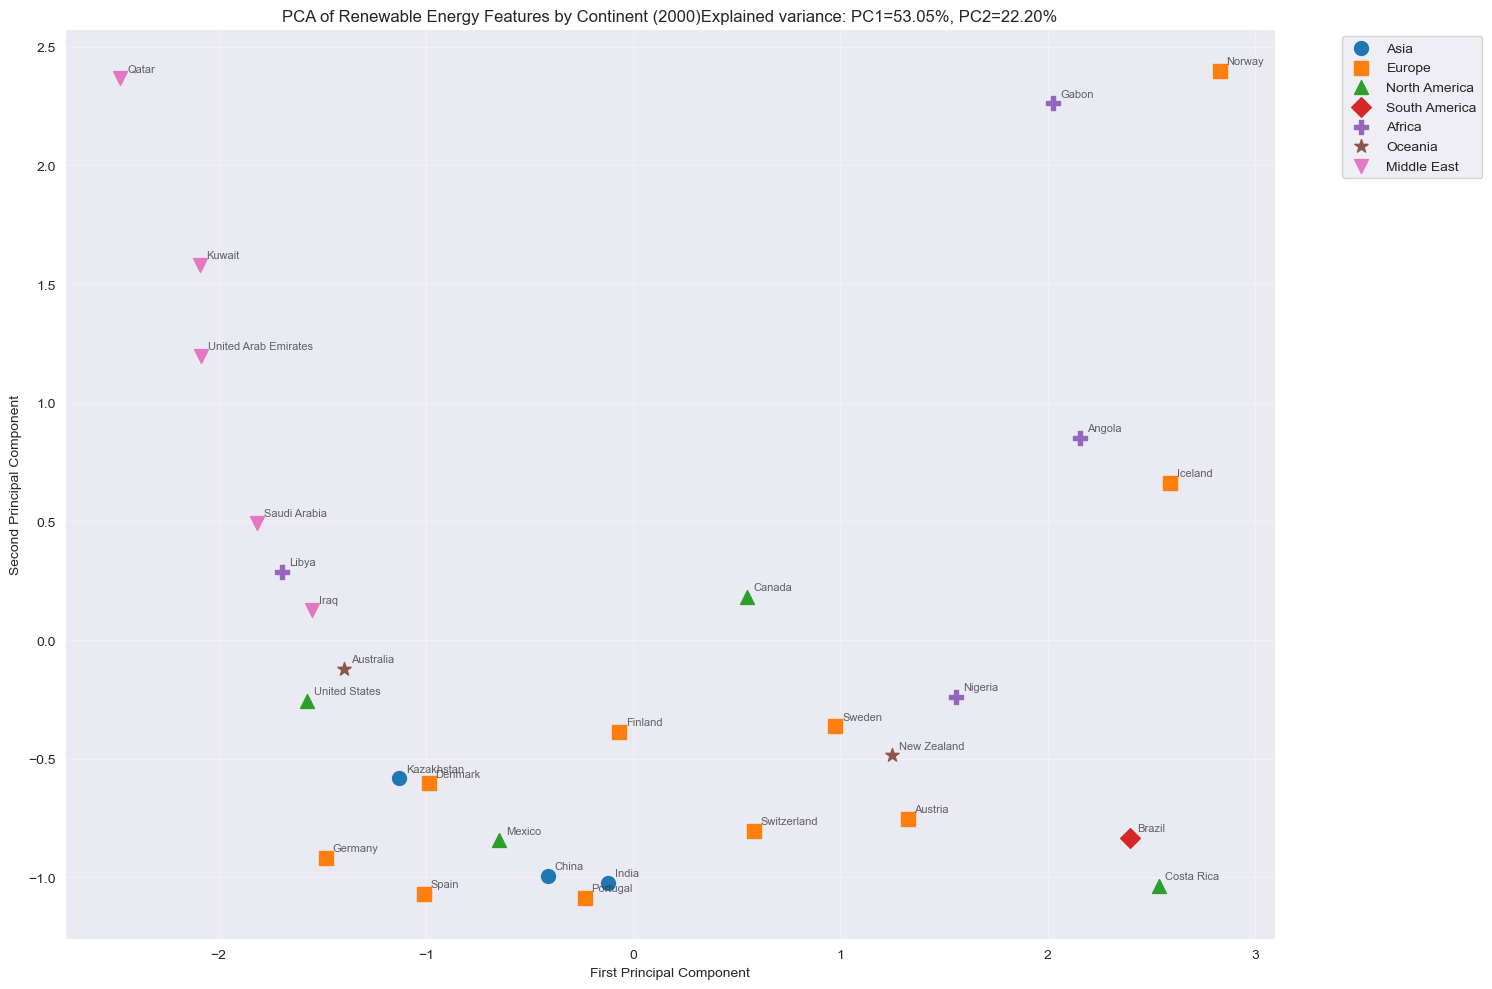

Feature contributions for 2000:
                                                         PC1       PC2
Renewables (% electricity)                          0.587269  0.029326
Renewable energy consumption (% of total final ...  0.520513  0.150014
Renewable electricity output (% of total electr...  0.585448  0.028901
Energy use (kg of oil equivalent per capita)       -0.203400  0.519654
Energy imports, net (% of energy use)               0.007772 -0.840096


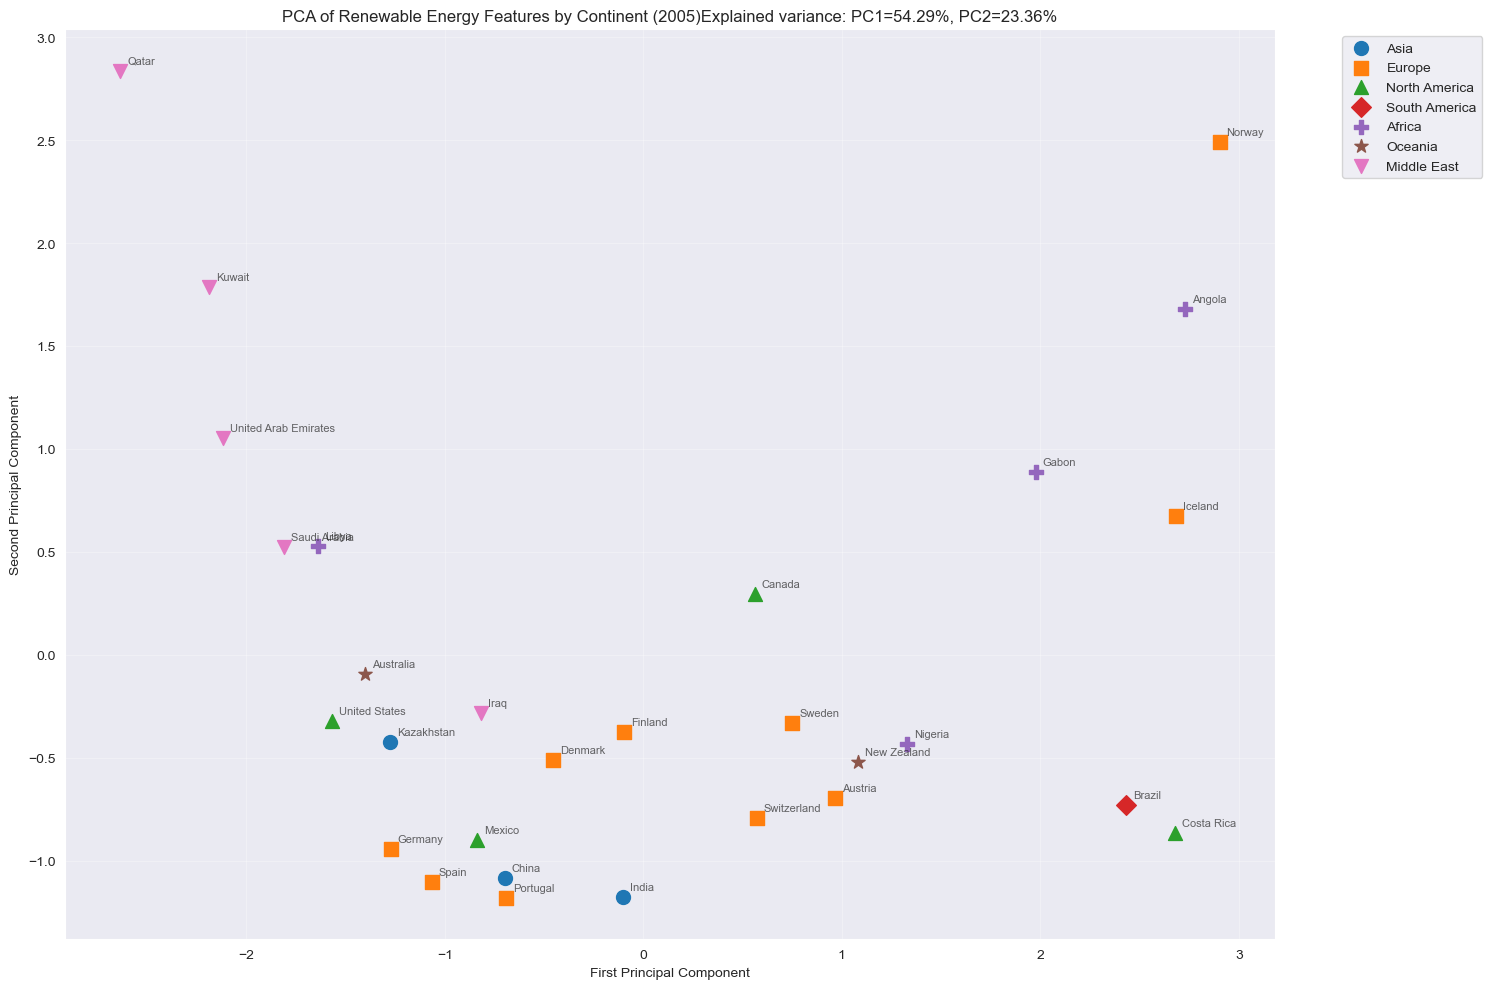

Feature contributions for 2005:
                                                         PC1       PC2
Renewables (% electricity)                          0.579907  0.068194
Renewable energy consumption (% of total final ...  0.521409  0.095442
Renewable electricity output (% of total electr...  0.579129  0.067221
Energy use (kg of oil equivalent per capita)       -0.237057  0.594284
Energy imports, net (% of energy use)              -0.015943 -0.792810


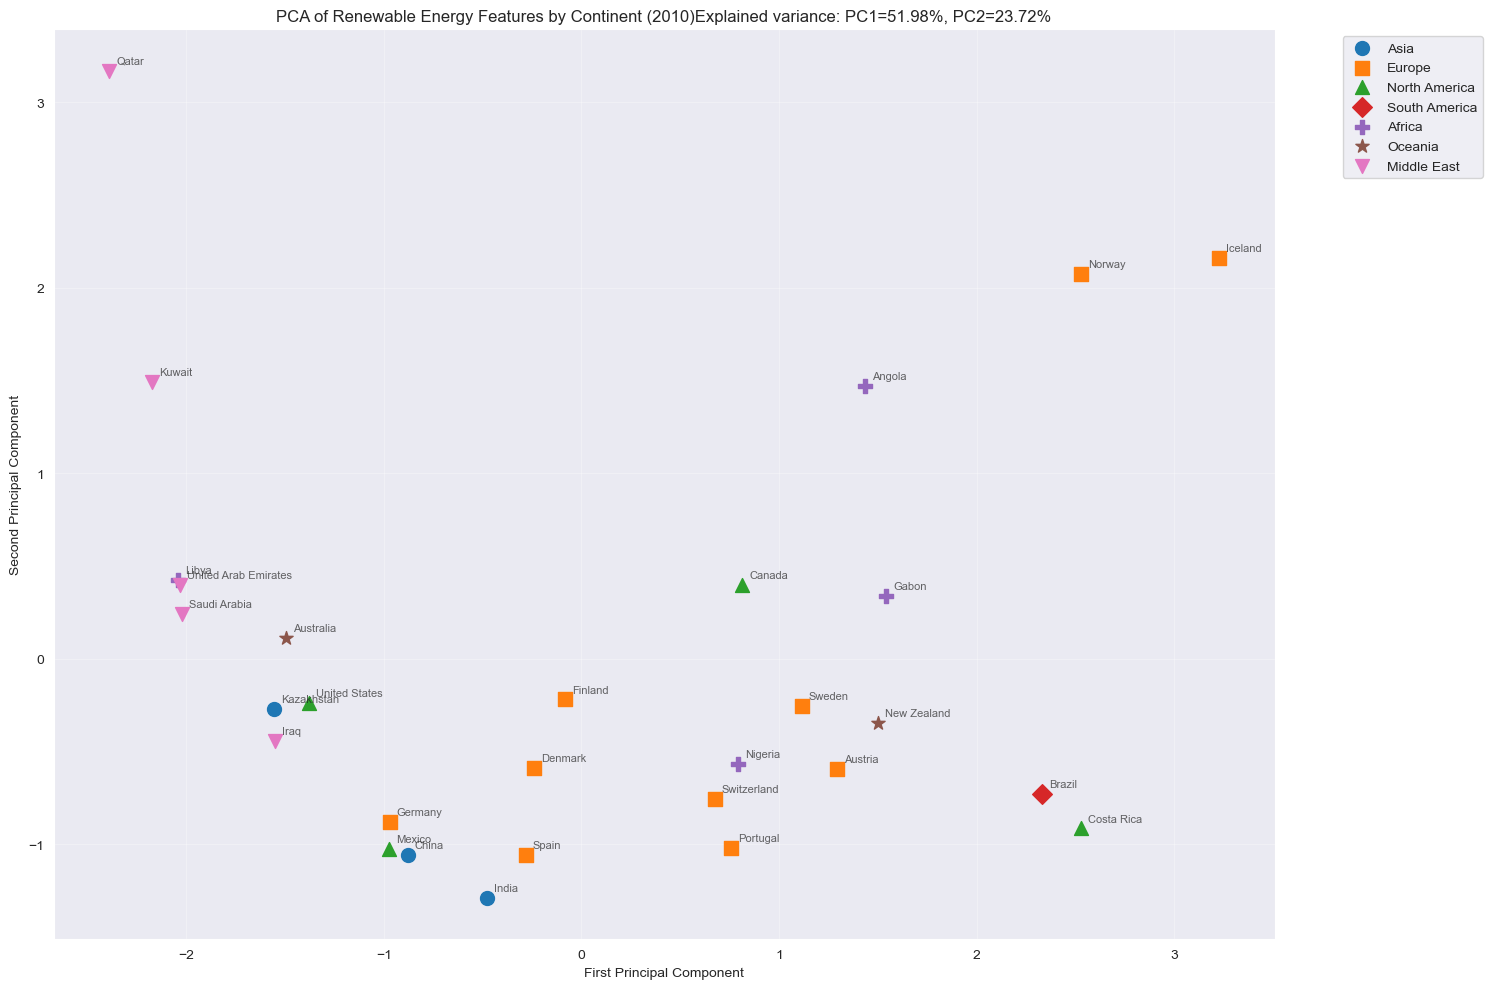

Feature contributions for 2010:
                                                         PC1       PC2
Renewables (% electricity)                          0.601113  0.072332
Renewable energy consumption (% of total final ...  0.509108  0.087788
Renewable electricity output (% of total electr...  0.600570  0.070386
Energy use (kg of oil equivalent per capita)       -0.067882  0.711519
Energy imports, net (% of energy use)               0.119084 -0.689818


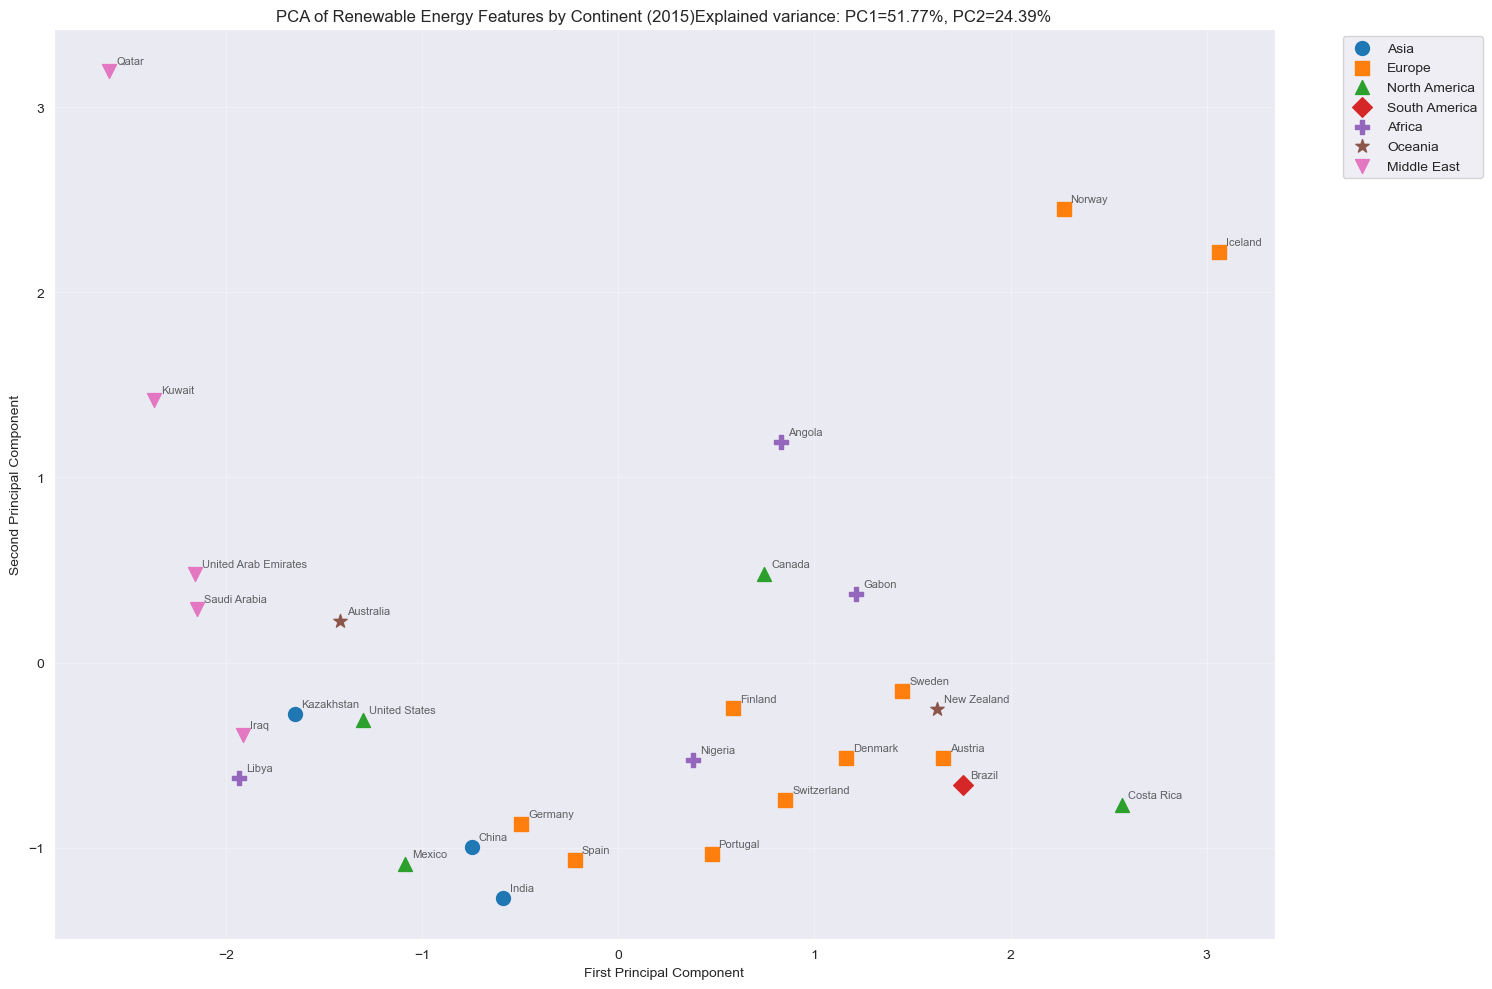

Feature contributions for 2015:
                                                         PC1       PC2
Renewables (% electricity)                          0.599260  0.101161
Renewable energy consumption (% of total final ...  0.498671  0.118310
Renewable electricity output (% of total electr...  0.599396  0.086229
Energy use (kg of oil equivalent per capita)       -0.090726  0.712819
Energy imports, net (% of energy use)               0.157185 -0.678397


In [20]:
for year in [2000, 2005, 2010, 2015]:
    plot_pca_for_year(filtered_countries_df, year)

In [21]:
major_countries = countries_to_explore = [
    'United States',
    'China',
    'Sweden',
    'Denmark',
    'Brazil',
    'Norway',
    'Iceland',
    'Saudi Arabia',
    'Qatar',
    'Australia',
    'Gabon',
    'Angola',
    'Libya',
    'United Arab Emirates'  # Full name for UAE
]

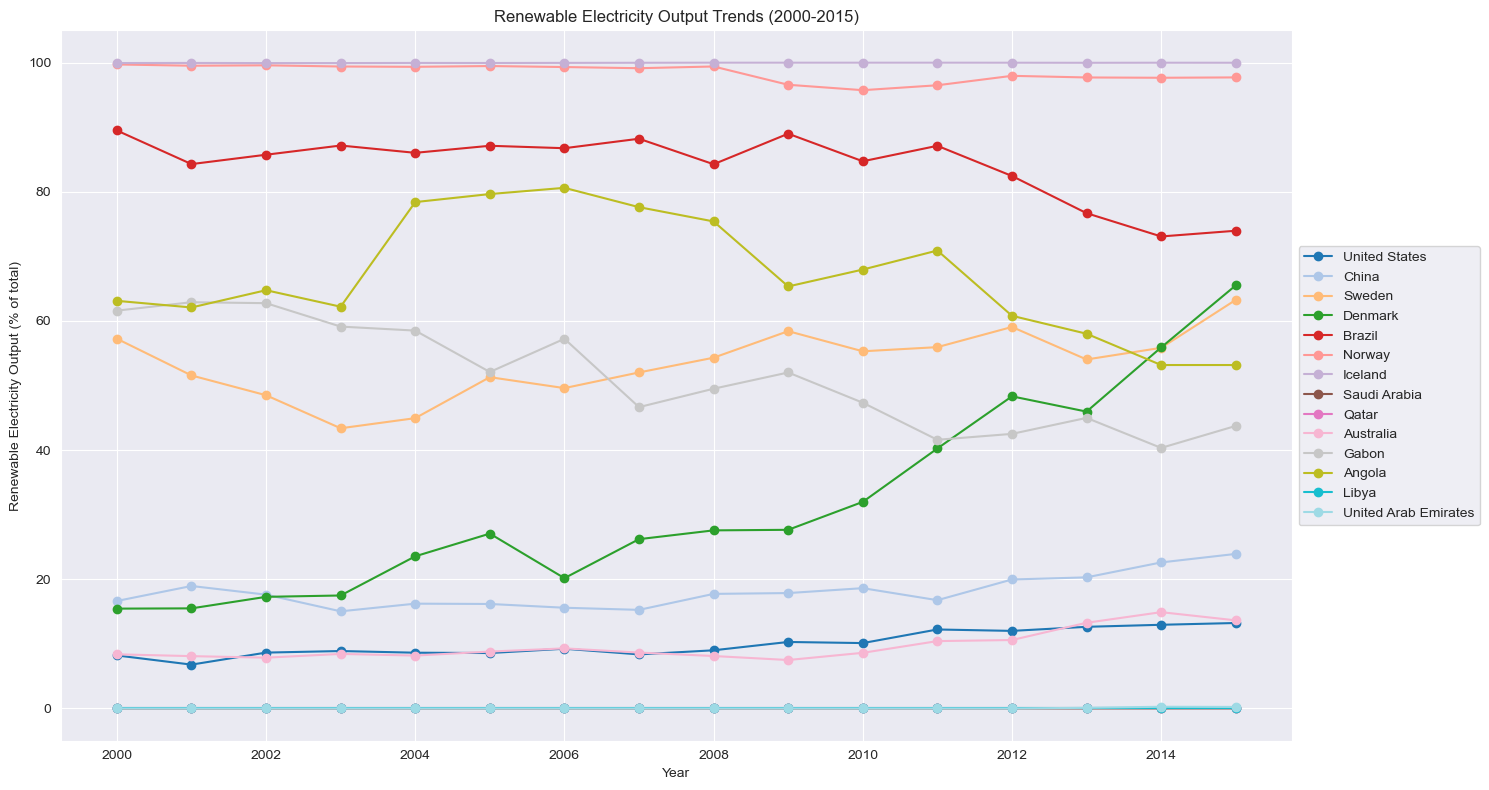

In [22]:
import matplotlib.cm as cm

# Filter data for the years 2000 to 2015
filtered_data = df[
    (df['Entity'].isin(major_countries)) & 
    (df['Year'] >= 2000) & (df['Year'] <= 2015)
]

# Generate a unique color for each country using a colormap
colors = cm.tab20(np.linspace(0, 1, len(major_countries)))

# Plot renewable electricity output trends from 2000 to 2015
plt.figure(figsize=(15, 8))
for country, color in zip(major_countries, colors):
    country_data = filtered_data[filtered_data['Entity'] == country]
    plt.plot(country_data['Year'], 
             country_data['Renewable electricity output (% of total electricity output)'],
             marker='o',
             label=country,
             color=color)

plt.title('Renewable Electricity Output Trends (2000-2015)')
plt.xlabel('Year')
plt.ylabel('Renewable Electricity Output (% of total)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
continents_list = ['Asia', 'Europe', 'North America', 'South America', 'Africa', 'Oceania', 'Middle East']

filtered_data = df[
    (df['Year'] >= 1995) & 
    (df['Year'] <= 2015) &
    (df['Continent'].isin(continents_list))
]

grouped_data = filtered_data.groupby(['Continent', 'Year'])[
    'Renewable electricity output (% of total electricity output)'
].mean().reset_index()

Average Renewable Electricity Output by Continent in 2015:


,Continent,Year,Renewable electricity output (% of total electricity output)
146,South America,2015,59.949432
125,Oceania,2015,46.859640
104,North America,2015,38.184283
62,Europe,2015,37.344622
20,Africa,2015,36.847518
41,Asia,2015,28.248409
83,Middle East,2015,9.449410


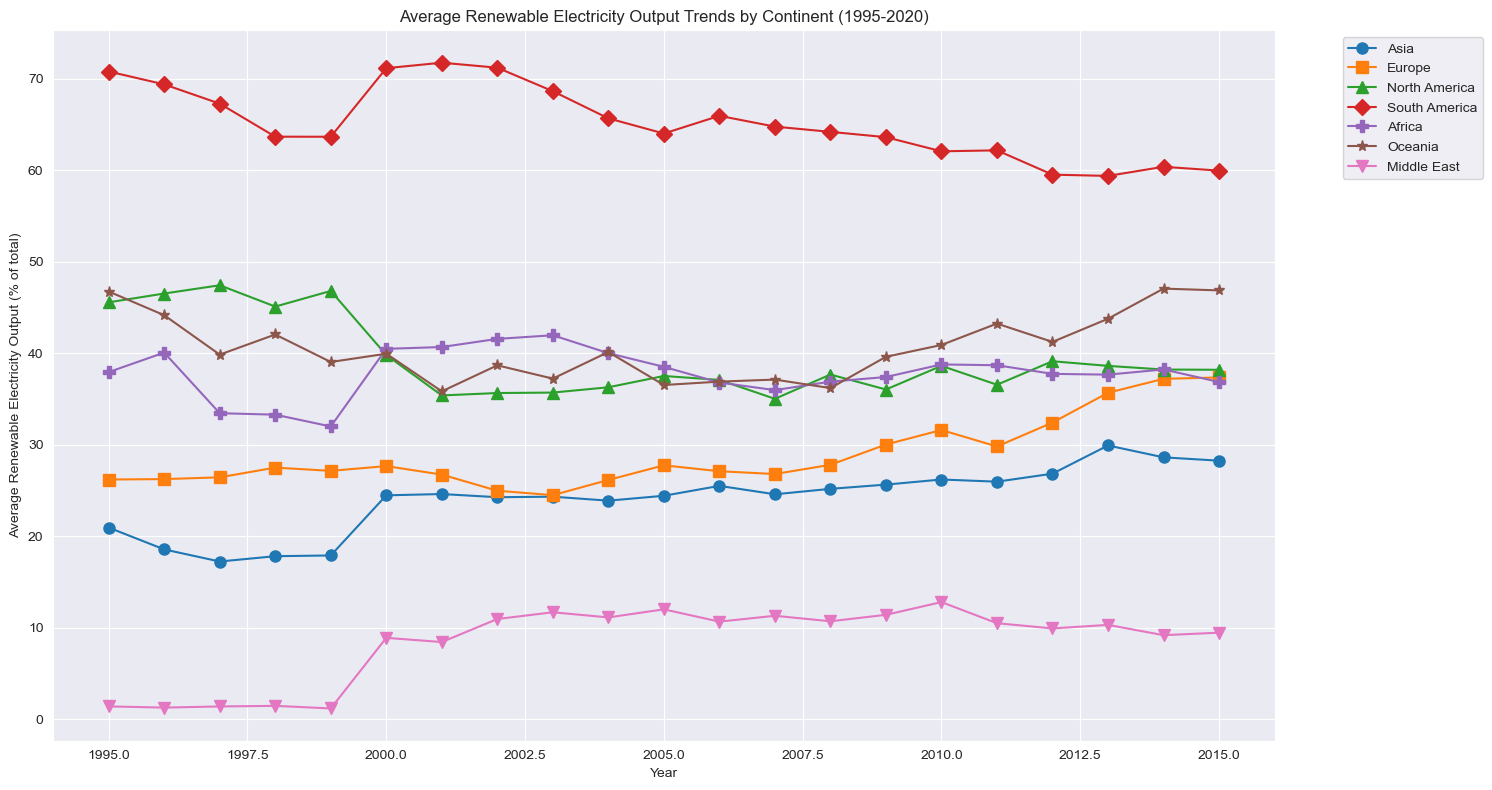

In [24]:
# Create the plot
plt.figure(figsize=(15, 8))

markers = {'Asia': 'o', 'Europe': 's', 'North America': '^', 
           'South America': 'D', 'Africa': 'P', 'Oceania': '*', 'Middle East': 'v'}

for continent in continents_list:
    continent_data = grouped_data[grouped_data['Continent'] == continent].dropna()
    plt.plot(continent_data['Year'], 
             continent_data['Renewable electricity output (% of total electricity output)'],
             marker=markers[continent],
             label=continent,
             markersize=8)

plt.title('Average Renewable Electricity Output Trends by Continent (1995-2020)')
plt.xlabel('Year')
plt.ylabel('Average Renewable Electricity Output (% of total)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

print("\
Average Renewable Electricity Output by Continent in 2015:")


data_frame = grouped_data[grouped_data['Year'] == 2015].sort_values(
    'Renewable electricity output (% of total electricity output)', 
    ascending=False
)

display(data_frame)

plt.tight_layout()
plt.show()